# day04-时间序列数据建模流程范例

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, losses, metrics, callbacks

(array([ 0., 10., 20., 30., 40., 50.]), <a list of 6 Text xticklabel objects>)

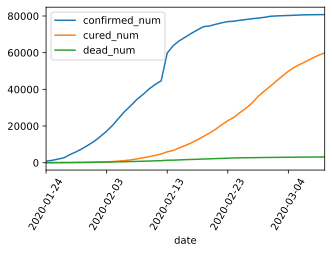

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"

df = pd.read_csv("./data/covid-19.csv", sep="\t")
df.plot(x="date", y=["confirmed_num", "cured_num", "dead_num"], figsize=(5, 3))
plt.xticks(rotation=60)

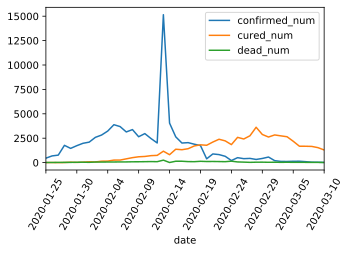

In [5]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x="date", y=["confirmed_num", "cured_num", "dead_num"], figsize=(5, 3))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date", axis=1).astype("float32")

In [6]:
# 用某日前8天的数据作为窗口输入，预测该日的数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE, drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values, dtype=tf.float32)) \
    .window(WINDOW_SIZE, shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values[WINDOW_SIZE:], dtype=tf.float32))

ds_train = tf.data.Dataset.zip((ds_data, ds_label)).batch(38).cache()

## 定义模型

In [7]:
# 函数式API构建任意结构模型
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)

    def call(self, x_input, x):
        x_out = tf.maximum((1 + x) * x_input[:,-1,:], 0.0)
        return x_out

    def get_config(self):
        config = super(Block, self).get_config()
        return config

In [8]:
tf.keras.backend.clear_session()

x_input = layers.Input(shape=(None, 3), dtype=tf.float32)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3))(x_input)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3))(x)
x = layers.LSTM(3, return_sequences=True, input_shape=(None, 3))(x)
x = layers.LSTM(3, input_shape=(None, 3))(x)
x = layers.Dense(3)(x)

x = Block()(x_input, x)
model = models.Model(inputs=[x_input], outputs=[x])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
block (Block)                (None, 3)                 0     

## 训练模型

In [9]:
# 自定义损失函数
class MSPE(losses.Loss):
    def call(self, y_true, y_pred):
        err_percent = (y_true - y_pred)**2 / (tf.maximum(y_true**2, 1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent

    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [11]:
import os
import datetime
from pathlib import Path

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss=MSPE(name="MSPE"))

# 使用Path根据操作系统修正路径
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = str(Path("./data/autograph/" + stamp))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# 如果loss在100个epoch后没有提升，学习率减半
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=100)
# 如果loss在200个epoch后没有提升，则提前停止学习
stop_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=200)
callbacks_list = [tb_callback, lr_callback, stop_callback]

history = model.fit(ds_train, epochs=500, callbacks=callbacks_list)

4/500
1/1 [==============================] - 0s 42ms/step - loss: 0.2787
Epoch 255/500
1/1 [==============================] - 0s 54ms/step - loss: 0.2791
Epoch 256/500
1/1 [==============================] - 0s 48ms/step - loss: 0.2784
Epoch 257/500
1/1 [==============================] - 0s 43ms/step - loss: 0.2787
Epoch 258/500
1/1 [==============================] - 0s 49ms/step - loss: 0.2783
Epoch 259/500
1/1 [==============================] - 0s 62ms/step - loss: 0.2784
Epoch 260/500
1/1 [==============================] - 0s 49ms/step - loss: 0.2781
Epoch 261/500
1/1 [==============================] - 0s 45ms/step - loss: 0.2781
Epoch 262/500
1/1 [==============================] - 0s 46ms/step - loss: 0.2779
Epoch 263/500
1/1 [==============================] - 0s 45ms/step - loss: 0.2779
Epoch 264/500
1/1 [==============================] - 0s 44ms/step - loss: 0.2777
Epoch 265/500
1/1 [==============================] - 0s 52ms/step - loss: 0.2778
Epoch 266/500
1/1 [=================

## 评估模型

In [12]:
# 考虑到数据较少，仅可视化损失函数在训练集上的迭代情况
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, "bo--")
    plt.title("Training" + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric])
    plt.show()

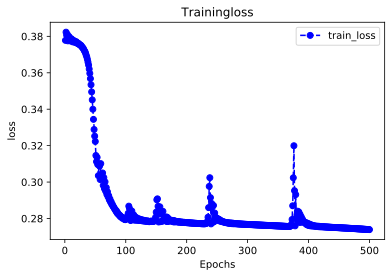

In [14]:
plot_metric(history, "loss")

## 使用模型

In [15]:
# 使用dfresult记录当前以及预测的数据
dfresult = dfdiff[["confirmed_num", "cured_num", "dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [16]:
# 预测此后100天的走向，添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:], axis=0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict), tf.float32).numpy(), columns=dfresult.columns)
    dfresult = dfresult.append(dfpredict, ignore_index=True)

In [17]:
dfresult.query("confirmed_num==0").head()

,confirmed_num,cured_num,dead_num
52,0.0,395.0,24.0
53,0.0,333.0,25.0
54,0.0,281.0,26.0
55,0.0,237.0,27.0
56,0.0,200.0,28.0


In [18]:
dfresult.query("cured_num==0").head()

,confirmed_num,cured_num,dead_num
91,0.0,0.0,0.0
92,0.0,0.0,0.0
93,0.0,0.0,0.0
94,0.0,0.0,0.0
95,0.0,0.0,0.0


In [19]:
dfresult.query("dead_num==0").head()

,confirmed_num,cured_num,dead_num
73,0.0,17.0,0.0
74,0.0,20.0,0.0
75,0.0,23.0,0.0
76,0.0,25.0,0.0
77,0.0,24.0,0.0


## 保存模型

In [22]:
savedir = str(Path("./model/day04/tf_model_savemodel"))
model.save(savedir, save_format="tf")

INFO:tensorflow:Assets written to: model\day04\tf_model_savemodel\assets
